In [1]:
#inspect_stock_data.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#23 January 2018
#
#this reads some NYSE data and makes some charts

In [2]:
#prep matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

In [3]:
#import numpy and pandas
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

In [4]:
#select date ranges, for plotting and for models
plot_date_range  = ('2016-02-01', '2016-10-01')
model_date_range = ('2017-01-12', '2018-01-12')

In [5]:
#read NYSE data
path = 'private/eoddata/NYSE_*.zip'
#path = 'private/eoddata/NYSE_2016.zip'
data_date_range  = ('2016-01-10', '2017-01-01')
drop_holidays = True
from helper_fns import *
market = read_market_data(path, drop_holidays=drop_holidays)
print 'number of records (M) = ', len(market)/1.0e5
print 'number of tickers = ', len(market.ticker.unique())
print 'number of dates = ', len(market.date.unique())
print market.dtypes
market.head(6)

reading file =  private/eoddata/NYSE_2013.zip
reading file =  private/eoddata/NYSE_2014.zip
reading file =  private/eoddata/NYSE_2015.zip
reading file =  private/eoddata/NYSE_2016.zip
reading file =  private/eoddata/NYSE_2017.zip
reading file =  private/eoddata/NYSE_2018.zip
number of records (M) =  33.24493
number of tickers =  3177
number of dates =  1264
ticker            object
date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
vol                int64
dtype: object


,ticker,date,open,high,low,close,vol
0,A,2013-01-02,30.1645,30.1645,29.4349,29.9571,6290000
1,AA,2013-01-02,26.6400,26.9700,26.5200,26.9700,21047600
2,AAN,2013-01-02,28.7200,28.7800,28.3000,28.7000,463500
3,AAP,2013-01-02,73.7400,73.7600,71.6900,72.4900,800400
4,AAT,2013-01-02,28.4900,28.7900,28.2500,28.5300,240900
5,AAV,2013-01-02,3.2800,3.3000,3.1800,3.2000,185500


In [6]:
#compute cumulative-sum of daily dollar-volume
N_days = (market.date.max() - market.date.min()).days
market['dollar_rate'] = market['open']*market['vol']/N_days
G_dpd_cs = market.groupby('ticker')['dollar_rate'].sum().sort_values(ascending=False).cumsum()/1.0e9
G_dpd_cs.head(5)

ticker
BAC     1.101142
BABA    1.913515
C       2.661735
JPM     3.407627
GE      4.151747
Name: dollar_rate, dtype: float64

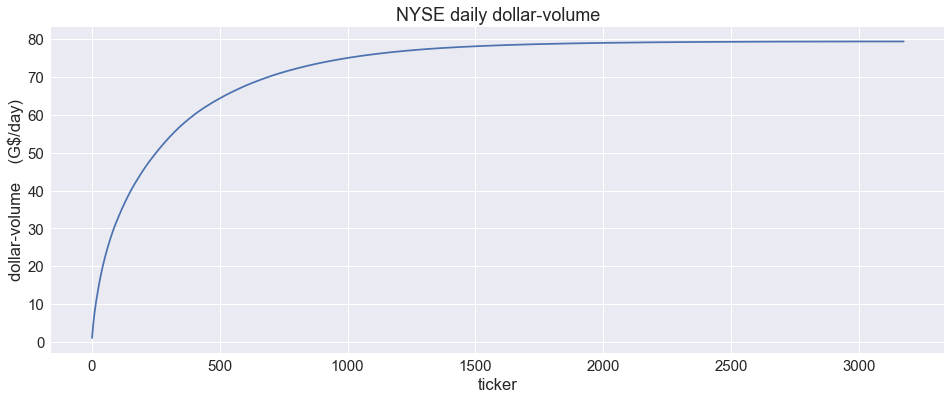

In [7]:
#plot giga_dpd_cs versus ticker
yp = G_dpd_cs
xp = range(len(yp))
fig, ax = plt.subplots(figsize=(16, 6))
p = ax.plot(xp, yp, linestyle='-')
p = ax.set_title('NYSE daily dollar-volume')
p = ax.set_xlabel('ticker')
p = ax.set_ylabel('dollar-volume    (G$/day)')
#plt.savefig('figs/volume.png')

In [8]:
#get top 500 tickers by traded dollar value
N_tickers = 5#00
tickers = G_dpd_cs.index[0:N_tickers].values.tolist()
print tickers

['BAC', 'BABA', 'C', 'JPM', 'GE']


In [10]:
#resample across 1-week time-bins, pivot data, and lag 'close' column by 1 week
#this drops companies that formed midway...needs to be fixed...
freq = 'w'
market_resampled, dfr = resample_data(market, freq, tickers=tickers)
print 'market_resampled.shape = ', market_resampled.shape
print 'market_resampled.columns = ', market_resampled.columns
market_resampled.head()
#dfr.head()
#dfr.tail()

market_resampled.shape =  (263, 16)
market_resampled.columns =  Index([u'close_BAC', u'close_C', u'close_GE', u'close_JPM', u'G$vol_BAC',
       u'G$vol_C', u'G$vol_GE', u'G$vol_JPM', u'std_BAC', u'std_C', u'std_GE',
       u'std_JPM', u'delta_BAC', u'delta_C', u'delta_GE', u'delta_JPM'],
      dtype='object')


,close_BAC,close_C,close_GE,close_JPM,G$vol_BAC,G$vol_C,G$vol_GE,G$vol_JPM,std_BAC,std_C,std_GE,std_JPM,delta_BAC,delta_C,delta_GE,delta_JPM
date,,,,,,,,,,,,,,,,
2013-01-07,12.11,42.43,21.20,45.36,6.318712,5.379975,2.666945,3.585969,0.003320,0.010646,0.008161,0.005900,-0.042798,-0.004701,-0.001418,0.022153
2013-01-14,11.63,42.34,21.13,46.14,12.505594,8.251036,3.726160,5.157513,0.019404,0.004898,0.003931,0.007625,-0.040482,-0.016525,0.040604,0.012421
2013-01-22,11.14,41.66,22.04,46.46,10.427859,8.906063,5.890322,7.469413,0.015319,0.012730,0.017029,0.008310,0.044964,0.037727,0.004959,0.019676
2013-01-28,11.62,42.91,22.29,47.16,5.545550,5.694996,4.227294,4.147268,0.021090,0.018128,0.007161,0.005373,0.006014,0.000931,0.008021,0.021563
2013-02-04,11.71,43.02,22.62,47.85,6.130303,5.602524,4.445154,4.801918,0.010248,0.010549,0.005738,0.008684,0.015544,0.007316,0.004016,0.022928


In [11]:
#get x = model features and y=target variables
substrings = ['close', 'G$vol', 'std']
cols = []
for col in market_resampled.columns:
    for s in substrings:
        if (s in col):
            cols += [col]
x = market_resampled[cols]
print 'x.shape = ', x.shape
x.head()

x.shape =  (263, 12)


,close_BAC,close_C,close_GE,close_JPM,G$vol_BAC,G$vol_C,G$vol_GE,G$vol_JPM,std_BAC,std_C,std_GE,std_JPM
date,,,,,,,,,,,,
2013-01-07,12.11,42.43,21.20,45.36,6.318712,5.379975,2.666945,3.585969,0.003320,0.010646,0.008161,0.005900
2013-01-14,11.63,42.34,21.13,46.14,12.505594,8.251036,3.726160,5.157513,0.019404,0.004898,0.003931,0.007625
2013-01-22,11.14,41.66,22.04,46.46,10.427859,8.906063,5.890322,7.469413,0.015319,0.012730,0.017029,0.008310
2013-01-28,11.62,42.91,22.29,47.16,5.545550,5.694996,4.227294,4.147268,0.021090,0.018128,0.007161,0.005373
2013-02-04,11.71,43.02,22.62,47.85,6.130303,5.602524,4.445154,4.801918,0.010248,0.010549,0.005738,0.008684


In [19]:
#get y=target variables
substrings = ['delta']
cols = []
for col in market_resampled.columns:
    for s in substrings:
        if (s in col):
            cols += [col]
y = market_resampled[cols]
print 'y.shape = ', y.shape
y.head()

y.shape =  (263, 4)


,delta_BAC,delta_C,delta_GE,delta_JPM
date,,,,
2013-01-07,-0.042798,-0.004701,-0.001418,0.022153
2013-01-14,-0.040482,-0.016525,0.040604,0.012421
2013-01-22,0.044964,0.037727,0.004959,0.019676
2013-01-28,0.006014,0.000931,0.008021,0.021563
2013-02-04,0.015544,0.007316,0.004016,0.022928


In [13]:
#test-train-validation split is 1:1:1
train_fraction = 0.333
rn_seed = 14
from sklearn.model_selection import train_test_split
x_train, x_test_validate, y_train, y_test_validate = train_test_split(x, y, train_size=train_fraction, 
    test_size=(1-train_fraction), random_state=rn_seed)
train_fraction = 0.5
x_test, x_validate, y_test, y_validate = train_test_split(x_test_validate, y_test_validate, train_size=train_fraction,
    test_size=(1-train_fraction), random_state=rn_seed)
print x.shape, y.shape
print x_train.shape, y_train.shape
print x_test.shape, y_test.shape
print x_validate.shape, y_validate.shape

(263, 12) (263, 4)
(87, 12) (87, 4)
(88, 12) (88, 4)
(88, 12) (88, 4)


In [18]:
#this helper function builds a simple MLP classifier
def mlp_classifier(layers, dropout_fraction=None):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    model = Sequential()
    N_inputs = layers[0]
    model.add(Dense(N_inputs, activation='elu', input_shape=(N_inputs,)))
    if (dropout_fraction):
        model.add(Dropout(dropout_fraction))
    for N in layers[1:-1]:
        model.add(Dense(N, activation='elu'))
        if (dropout_fraction):
            model.add(Dropout(dropout_fraction))
    N_outputs = layers[-1]
    model.add(Dense(N_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [21]:
#build MLP classification model 
N_inputs = x.shape[1]
N_outputs = y.shape[1]
N_middle = (N_inputs + N_outputs)/2
layers = [N_inputs, N_middle, N_outputs]
dropout_fraction = 0.2
print 'layers = ', layers
print 'dropout_fraction = ', dropout_fraction
model = mlp_classifier(layers, dropout_fraction=dropout_fraction)
model.summary()

layers =  [12, 8, 4]
dropout_fraction =  0.2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12)                156       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 104       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
Total params: 296
Trainable params: 296
Non-trainable params: 0
_________________________________________________________________


In [27]:
#fit model
N_epochs = 21
batch_size = 1
fit_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=N_epochs, verbose=0, 
    validation_data=(x_validate, y_validate))

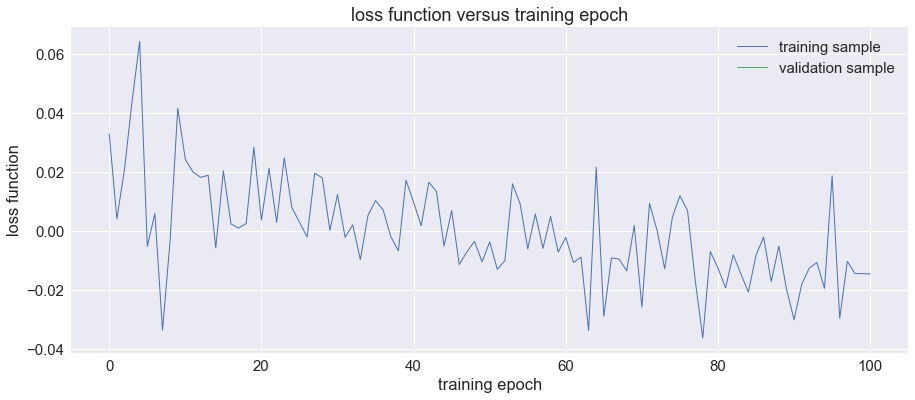

In [26]:
#plot loss vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
p = ax.plot(xp, yp, linewidth=1, label='training sample')
yp = fit_history.history['val_loss']
p = ax.plot(xp, yp, linewidth=1, label='validation sample')
p = ax.set_title('loss function versus training epoch')
p = ax.set_ylabel('loss function')
p = ax.set_xlabel('training epoch')
p = ax.legend()
#plt.savefig('figs/loss.png')

In [ ]:
ticker = 'GE'
df = market
idx = (df['ticker'] == ticker)
df = df[idx].set_index('date')
fig, ax = plt.subplots(1,1, figsize=(15, 6))
yp = df['open']
ax.plot(yp, marker='o', markersize=3, linestyle='-', label='open')
yp = df['close']
ax.plot(yp, marker='o', markersize=3, linestyle='-', label='close')
df = market_resampled
idx = (df['ticker'] == ticker)
df = df[idx].set_index('date')
yp = df['open']
xp = yp.index
err = df['std']
ax.errorbar(xp, yp, yerr=err, marker='o', markersize=9, linestyle='-.', alpha=0.6, label='weekly avg')
df = df.set_index('date_lagged')
yp = df['open']
xp = yp.index
ax.plot(yp, marker='o', markersize=9, linestyle='-.', label='open/lagged')
ax.set_title('ticker = ' + ticker)
ax.set_ylabel('share price')
ax.set_xlabel('date')
ax.set_xlim(plot_date_range)
ax.legend()
#plt.savefig('figs/field_parameters.png')

In [ ]:
market_resampled.head()

In [ ]:
#compute volume of shares traded each day
daily_volume = market.groupby('date')['vol'].sum()
daily_volume.head(10)

In [ ]:
#plot daily volume vs date
fig, ax = plt.subplots(figsize=(16, 6))
xp = daily_volume.index
yp = daily_volume.values/1.0e9
p = ax.plot(xp, yp, linestyle='-')
ax.set_title('NYSE daily share volume')
ax.set_xlabel('date')
ax.set_ylabel('shares traded    (G)')
ax.set_ylim(0, 8)
ax.set_xlim(plot_date_range)
plt.savefig('figs/volume.png')

In [ ]:
#compute volume-weighted share price versus date
def volume_weighted_share_price(record):
    vwsp = None
    cv = record['close']*record['vol']
    v_total = record['vol'].sum()
    if (v_total > 0.0):
        vwsp = cv.sum()/v_total
    return vwsp
vwsp = market.groupby('date').apply(volume_weighted_share_price)

In [ ]:
#plot volume-weighted share price vs date
fig, ax = plt.subplots(figsize=(16, 6))
xp = vwsp.index
yp = vwsp.values
p = ax.plot(xp, yp, linestyle='-')
ax.set_title('NYSE volume-weighted mean share price')
ax.set_xlabel('date')
ax.set_ylabel('volume-weighted share price')
ax.set_ylim(31, 45)
ax.set_xlim(plot_date_range)
plt.savefig('figs/vwsp.png')

In [ ]:
#plot fractional volume-weighted gain vs date
fig, ax = plt.subplots(figsize=(16, 6))
xp = vwsp.index
yp = vwsp.values
yp = (yp - yp[0])/yp[0]
p = ax.plot(xp, yp, linestyle='-')
p = ax.set_title('fractional change in NYSE volume-weighted mean share price')
p = ax.set_xlabel('date')
p = ax.set_ylabel('fractional gain')
p = ax.set_xlim(plot_date_range)
plt.savefig('figs/fractional_vwsp.png')

In [ ]:
#simulate mean outcome for 25 people, each trading $10K worth of randomly selected tickers daily
N_buyers = 25
N_tickers = 5
initial_dollars = 10000.0
idx = (market['date'] >= model_date_range[0]) & (market['date'] <= model_date_range[1])
market_data = market[idx]
ran_purchases = random_purchases(market_data, N_buyers, N_tickers, initial_dollars)

In [ ]:
#plot mean fractional gain exhibited by random purchasers
fig, ax = plt.subplots(figsize=(16, 6))
xp = ran_purchases.index.values
yp = ran_purchases['dollars_mean'].values
err = ran_purchases['dollars_std'].values/yp[0]
yp = (yp -yp[0])/yp[0]
p = ax.plot(xp, yp, linestyle='-')
p = ax.errorbar(xp, yp, err, linestyle='none', alpha=0.5)
ax.set_title('simulated outcome for daily random purchases')
ax.set_xlabel('date')
ax.set_ylabel('fractional gain')
ax.set_xlim(model_date_range)
plt.savefig('figs/random_purchases.png')